# Enhancing Model Robustness with Out-of-Distribution Detection Using Geti SDK

Out-of-Distribution (OOD) detection identifies images that do not belong to the categories a model was trained on. 
By incorporating OOD detection during inference, we improve the model's robustness and safety, ensuring that only relevant, in-distribution images are processed.
This helps in reducing errors caused by unfamiliar data.

In this demo :
- We will create an Out-of-Distribution model using the Geti SDK. Specifically we will use the Combined Out-of-Distribution (COOD) model.
- We will fetch a deployment from an existing Trained Geti project.
- We will attach a OODTrigger to a post inference hook to save the detected OOD images to a new directory.

The idea is that, during inference, if an OOD image is encountered, instead of taking any action based on the unreliable prediction, we will save the image to a new directory. This directory can be used for further analysis or training.

## Step 1 : Connect to a Geti instance and Selecting a Project

In [1]:
# As usual, we will connect to the platform first, using the server details from the .env file
import os

from geti_sdk import Geti
from geti_sdk.utils import get_server_details_from_env

os.environ["NO_ALBUMENTATIONS_UPDATE"] = "1"

geti_server_configuration = get_server_details_from_env(
    env_file_path="/Users/rgangire/workspace/code/repos/Geti-SDK/dev/geti-sdk/notebooks/use_cases/.env"
)

geti = Geti(server_config=geti_server_configuration)

### Selecting a project

We'll use the `CUB6` classification project that is already created.  
This project contains 6 classes of birds with each class having 50 images. The project is already trained and ready for deployment.

In [2]:
from geti_sdk.rest_clients import ModelClient, ProjectClient

PROJECT_NAME = "CUB6"

project_client = ProjectClient(session=geti.session, workspace_id=geti.workspace_id)
project = project_client.get_project_by_name(project_name=PROJECT_NAME)
model_client = ModelClient(
    session=geti.session, workspace_id=geti.workspace_id, project=project
)

print(f"Labels in the project : {[label.name for label in project.get_all_labels()]}")

Labels in the project : ['Laysan Albatross', 'Western Wood Pewee', 'Field Sparrow', 'Artic Tern', 'Black and White Warbler', 'Downy Woodpecker']


## Step 2 : Creating a deployment.

The OOD detection model uses feature vectors from the trained model to detect out-of-distribution images.  
Therefore, we need to create a deployment with a model that has an XAI head. We will use the `get_deployment_with_xai_head` function to get a deployment with an XAI head.
Optionally, if a deployment is not passed, the COOD model will fetch a deployment with an XAI head from the project.

In [3]:
from geti_sdk.detect_ood.utils import get_deployment_with_xai_head

deployment = get_deployment_with_xai_head(geti=geti, model_client=model_client)

2024-09-20 15:23:15,764 - INFO - Loading faiss.
2024-09-20 15:23:15,795 - INFO - Successfully loaded faiss.
2024-09-20 15:23:22,822 - INFO - Deployment for project 'CUB6' started.
2024-09-20 15:23:22,830 - INFO - Waiting for the deployment to be created...
2024-09-20 15:23:26,694 - INFO - Downloading project deployment archive...
2024-09-20 15:23:29,459 - INFO - Deployment for project 'CUB6' downloaded and extracted successfully.


## Step 3 : Creating the Combined Out-of-Distribution (COOD) Model

Combined Out-of-Distribution or COOD is a framework for OOD detection model that combines individual OOD measures into one combined OOD measure using a supervised model.
It is shown that the COOD model outperforms the individual OOD measures in detecting OOD images especially in practical/real-world scenarios.
More about COOD : https://arxiv.org/abs/2403.06874

The COOD model requires in-distribution and out-of-distribution images for training.
Typically, OOD images are images that are not from the classes the model was trained and/or images on which the model should not be making confident predictions.
These can include images from different classes, corrupted images, background classes, etc.

__In-distribution data:__ Images from the project's default dataset `Dataset` are used as in-distribution images.  
__Out-of-distribution data:__  For providing OOD images for training, there are few options : 
- Provide a directory containing the OOD images.
- Use predetermined OOD datasets, if available, in the Geti project.
- Generate OOD images by applying strong corruptions on the in-distribution images.

In this example, we will use the simplest option - provide a directory containing examples of OOD images for training the COOD model.


Internally, the COOD model runs inference on all the in-distribution and out-of-distribution images and trains a classifier to combine the individual OOD measures into one COOD measure.   
__Note:__ This should take around 30 seconds. 

In [4]:
from geti_sdk.detect_ood.ood_model import COODModel

# A directory to store the data downloaded and generated by the COOD model. If not provided, a temporary directory will be used.
OOD_WORKSPACE_DIR = "/Users/rgangire/workspace/Results/SDK/COOD_MODEL_WS"

# A directory containing the OOD images. These images will be used to train the COOD model.
OOD_IMAGES_DIR_TRAIN = "/Users/rgangire/workspace/Results/SDK/OOD_DATA/OOD_TRAIN"

# Create the COOD model - This also trains the COOD model.
ood_model = COODModel(
    geti=geti,
    project=project,
    deployment=deployment,
    ood_images_dir=OOD_IMAGES_DIR_TRAIN,
    workspace_dir=OOD_WORKSPACE_DIR,
)

2024-09-20 15:23:29,730 - INFO - Reading model /var/folders/f1/7tc0dfks1j590_v7st0w309r0000gn/T/tmp9cdzlddr/deployment/Classification/model/model.xml
2024-09-20 15:23:30,074 - INFO - The model /var/folders/f1/7tc0dfks1j590_v7st0w309r0000gn/T/tmp9cdzlddr/deployment/Classification/model/model.xml is loaded to CPU
2024-09-20 15:23:30,077 - INFO - 	Number of model infer requests: 1
2024-09-20 15:23:30,078 - INFO - Inference model wrapper initialized, force reloading model on device `CPU` to finalize inference model initialization process.
2024-09-20 15:23:30,270 - INFO - The model /var/folders/f1/7tc0dfks1j590_v7st0w309r0000gn/T/tmp9cdzlddr/deployment/Classification/model/model.xml is loaded to CPU
2024-09-20 15:23:30,272 - INFO - 	Number of model infer requests: 1
2024-09-20 15:23:30,272 - INFO - Inference models loaded on device `CPU` successfully.
2024-09-20 15:23:30,273 - INFO - Building Combined OOD detection model for Intel® Geti™ project `CUB6`.
2024-09-20 15:23:30,273 - INFO - Extr

2024-09-20 15:23:34,518 - INFO - No images were downloaded. 300 existing images were found in the target folder, download was skipped for these images.


2024-09-20 15:23:49,217 - INFO - Extracting OOD data from the provided reference images in /Users/rgangire/workspace/Results/SDK/OOD_DATA/OOD_TRAIN
2024-09-20 15:23:56,466 - INFO - Number of in-distribution samples: 300
2024-09-20 15:23:56,467 - INFO - Number of out-of-distribution samples: 349
2024-09-20 15:23:56,924 - INFO - Training COOD Model
2024-09-20 15:23:56,925 - INFO - Training data: ID - 210, OOD - 244
2024-09-20 15:23:57,006 - INFO - COOD Model Metrics on Training Data: 
 Accuracy: 1.0000
AUROC: 1.0000
F1 Score: 1.0000
TPR@1%FPR: 0.0000
TPR@5%FPR: 1.0000
2024-09-20 15:23:57,006 - INFO - COOD Model Metrics on Validation Data: 
 Accuracy: 0.9197
AUROC: 0.9704
F1 Score: 0.9281
TPR@1%FPR: 0.7027
TPR@5%FPR: 0.7568
2024-09-20 15:23:57,006 - INFO - COOD Model is trained and ready for inference.
2024-09-20 15:23:57,007 - INFO - Evaluating COOD Model on Test Data
2024-09-20 15:23:57,007 - INFO - Test data: ID - 90, OOD - 105
2024-09-20 15:23:57,019 - INFO - COOD Model Metrics on Tes

## Step 4 : Configuring a OODTrigger and Post Inference Hook to save detected OOD images

The COOD model is now trained. For a given image, the COOD model will output a score between 0 and 1. A score closer to 1 indicates that the image is OOD.

When an image is detected as OOD, it will be saved to a new directory.
The idea is to collect OOD images and use them for further analysis or training.

For this we will add a post inference hook to the deployment. The hook will be configured to behave as follows:

- If the image has a COOD score greater than a threshold :
- Save the image to a new directory.

For achieving the first part, we will use the OODTrigger, which will activate if the COOD score is greater than the threshold.  
The COOD model would also provide *optimal thresholds* for various use cases. For instance, if we prefer to have higher True Positives (OOD images detected as OOD) and can tolerate some False Positives (In-distribution images detected as OOD), we can choose a threshold for optimal *TPR@FPR5*. 
For this example, we will use the threshold that achieved highest F1 score, which is a balanced threshold across True Positives and False Positives.

For the second part, we will use the *FileSystemDataCollection* action to save the detected OOD images to a specified director ("OOD_IMAGES_COLLECTED"). 

More about Triggers and Post Inference Hooks can be found in the notebook 012_post_inference_hooks.ipynb

In [5]:
from geti_sdk.post_inference_hooks import (
    FileSystemDataCollection,
    OODTrigger,
    PostInferenceHook,
)

# The Trigger will activate whenever the COOD score is greater than the threshold.
ood_trigger = OODTrigger(
    ood_model=ood_model, threshold=ood_model.best_thresholds["fscore"]
)

# The action to be taken when the trigger activates
OOD_COLLECTION_DIR = "/Users/rgangire/workspace/Results/SDK/OOD_DATA/COLLECTED"
ood_action = FileSystemDataCollection(
    target_folder=OOD_COLLECTION_DIR,
    file_name_prefix="OOD_",
    save_predictions=False,
    save_scores=False,
    save_overlays=False,
)

# Create a hook with the trigger and action
ood_hook = PostInferenceHook(trigger=ood_trigger, action=ood_action)

# Add the hook to the deployment
deployment.add_post_inference_hook(ood_hook)

2024-09-20 15:23:57,030 - INFO - Hook `PostInferenceHook(trigger=OODTrigger(threshold=0.4), action=FileSystemDataCollection(target_folder=`/Users/rgangire/workspace/Results/SDK/OOD_DATA/COLLECTED`, file_prefix=OOD_, save_predictions=False, save_scores=False, save_overlays=False))[Multithreaded execution enabled. ]` added.
2024-09-20 15:23:57,031 - INFO - Deployment now contains 1 post inference hooks.


## Step 5 : Testing the OOD Detection on various images

We will now infer the deployment on various images to test the OOD detection.

### Example 1 : Image not containing a Bird

In this example, we show that an image that does not contain any bird is detected as a bird with a good confidence by the model.  
However, the COOD model detects this image as OOD and saves it to the specified directory.  
Such images are considered as intermediate OOD and are relatively easy to detect.

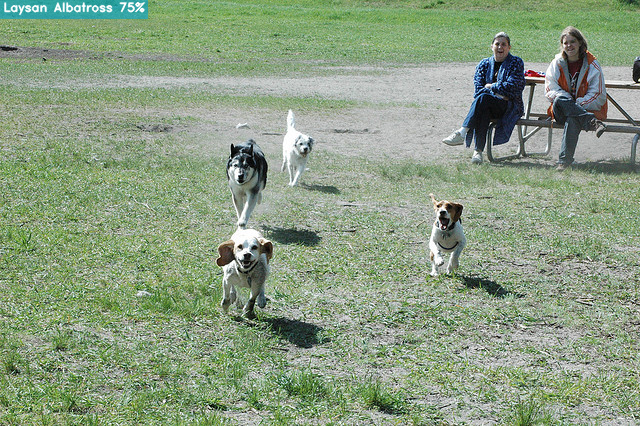

In [6]:
import shutil

import cv2

from geti_sdk import Visualizer
from geti_sdk.demos import EXAMPLE_IMAGE_PATH
from geti_sdk.detect_ood.utils import (
    count_images_in_directory,
    infer_images_in_directory,
)

numpy_image = cv2.imread(EXAMPLE_IMAGE_PATH)
numpy_rgb = cv2.cvtColor(numpy_image, cv2.COLOR_BGR2RGB)

prediction = deployment.explain(numpy_rgb)
visualizer = Visualizer()
result = visualizer.draw(numpy_rgb, prediction)
visualizer.show_in_notebook(result)

As we can see, the image is detected as a bird with a good confidence.   
However, this image would have been detected as OOD by the COOD model and saved to the specified directory.

### Example 2 : Images containing new species of birds

In this example, we show that an image containing a new species of bird is detected as OOD by the COOD model.  
This case is considered as Near OOD and is relatively harder to detect.  
There a total of 300 images of 5 different species of birds.  

Some of these OOD images might have a low prediction probability and therefore can also be detected as OOD with simple thresholding on the prediction probability.  
Therefore, we also consider a more difficult case in Example 3 - OOD images where the prediction probability is high (above 90). 

In [7]:
# We will consider a prediction with a probability of 0.9 (90%) as a "high confidence" prediction.
HIGH_CONFIDENCE_THRESHOLD = 0.9

# Directory containing the OOD images for testing. These are the new species of birds.
OOD_TEST_IMAGES_PATH = "/Users/rgangire/workspace/Results/SDK/OOD_DATA/OOD_TEST_SMALL"

# Directory to save the images with high confidence predictions.
OOD_COLLECTION_DIR_HIGH_PRED = (
    "/Users/rgangire/workspace/Results/SDK/OOD_DATA/COLLECT_PRED90"
)

Now, we will infer the deployment on the OOD images and check the results.
While inferring, we will also check the number of images detected as OOD by counting the number of images in the directory where the OOD images are saved.  
All the OOD images with a prediction probability greater than 90 are saved to a new directory as well. 

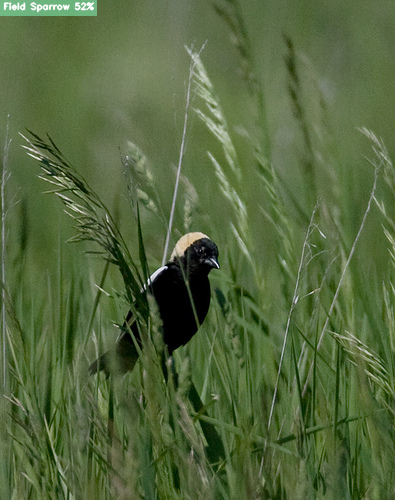

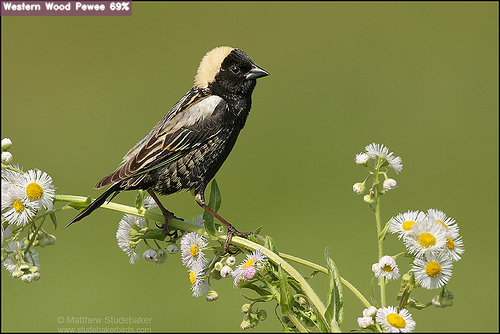

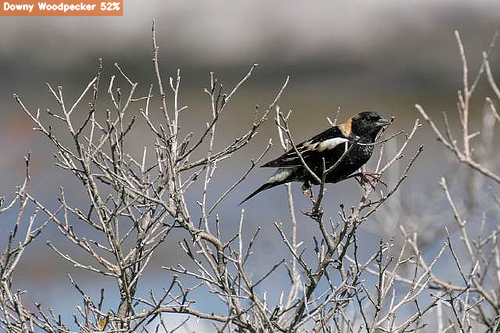

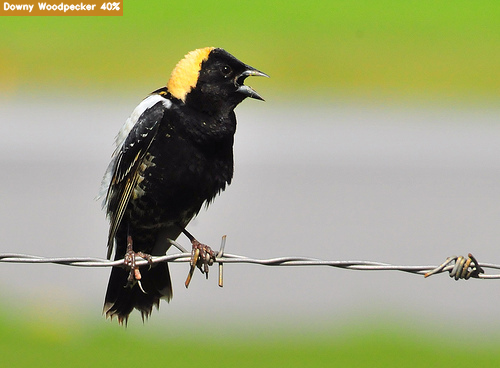

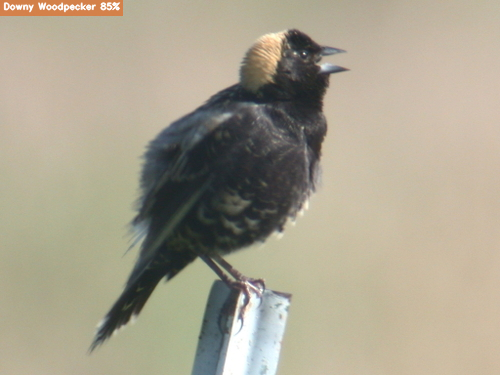

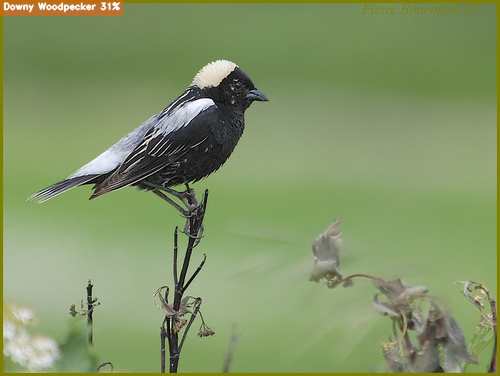

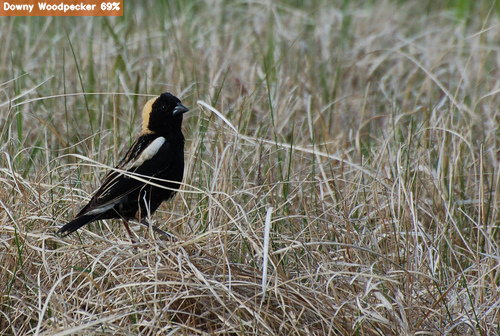

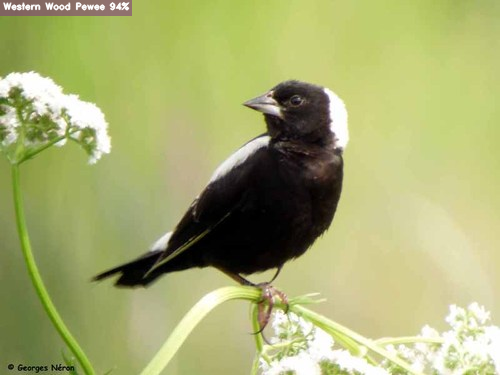

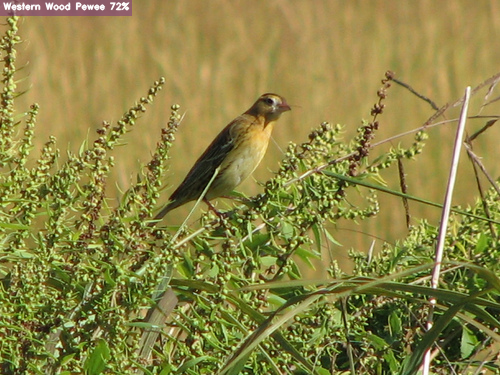

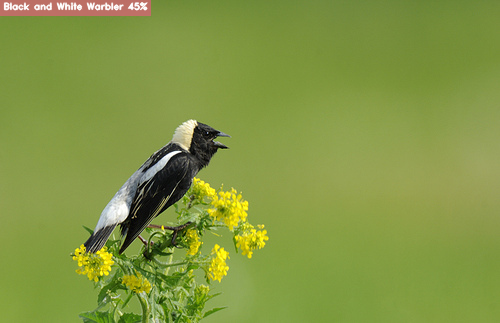

# of OOD test images : 300
# of imaged detected as OOD : 294 (98.00%)


In [12]:
# clean the directories before running the test
shutil.rmtree(OOD_COLLECTION_DIR_HIGH_PRED, ignore_errors=True)
os.makedirs(os.path.join(OOD_COLLECTION_DIR_HIGH_PRED, "images"), exist_ok=True)
shutil.rmtree(OOD_COLLECTION_DIR, ignore_errors=True)
os.makedirs(os.path.join(OOD_COLLECTION_DIR, "images"), exist_ok=True)

images_count_before = count_images_in_directory(
    OOD_COLLECTION_DIR, include_subdirectories=True
)
NUM_IMAGES_TO_SHOW = 10
test_images_count = 0
for image_path, image_numpy, prediction in infer_images_in_directory(
    OOD_TEST_IMAGES_PATH, deployment
):
    test_images_count += 1
    prediction_prob = prediction.annotations[0].labels[0].probability
    if prediction_prob > HIGH_CONFIDENCE_THRESHOLD:
        # Save high confidence predictions to a directory
        shutil.copy(image_path, OOD_COLLECTION_DIR_HIGH_PRED)
    if test_images_count <= NUM_IMAGES_TO_SHOW:
        visualizer = Visualizer()
        result = visualizer.draw(image_numpy, prediction)
        visualizer.show_in_notebook(result)

images_count_after = count_images_in_directory(
    OOD_COLLECTION_DIR, include_subdirectories=True
)
ood_detected_images = images_count_after - images_count_before
print(f"# of OOD test images : {test_images_count}")
print(
    f"# of imaged detected as OOD : {ood_detected_images} ({ood_detected_images/test_images_count*100:.2f}%)"
)

### Example 3 : Testing the OOD images with high confidence predictions

We will now test the OOD images with high confidence predictions. These images were saved to a new directory during hte previous step.  
These are the harder cases of OOD images where the model is confident about the prediction and hence can not be detected using simple thresholding on the prediction probability.  

In [13]:
# Keep only the OOD hook and remove the high confidence hook as we do not need to save the images again.
deployment.clear_inference_hooks()
deployment.add_post_inference_hook(ood_hook)

2024-09-20 15:26:09,715 - INFO - Post inference hooks cleared. 1 hooks were removed successfully
2024-09-20 15:26:09,716 - INFO - Hook `PostInferenceHook(trigger=OODTrigger(threshold=0.4), action=FileSystemDataCollection(target_folder=`/Users/rgangire/workspace/Results/SDK/OOD_DATA/COLLECTED`, file_prefix=OOD_, save_predictions=False, save_scores=False, save_overlays=False))[Multithreaded execution enabled. ]` added.
2024-09-20 15:26:09,716 - INFO - Deployment now contains 1 post inference hooks.


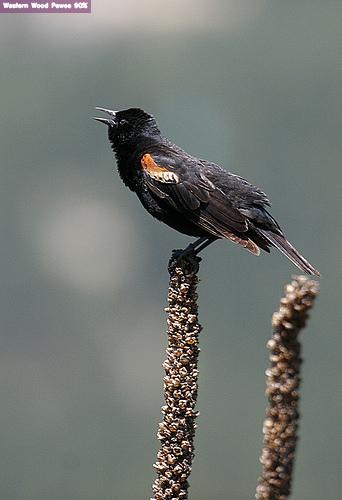

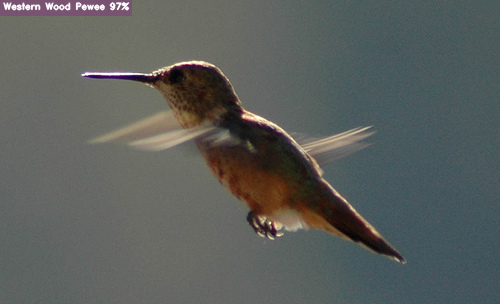

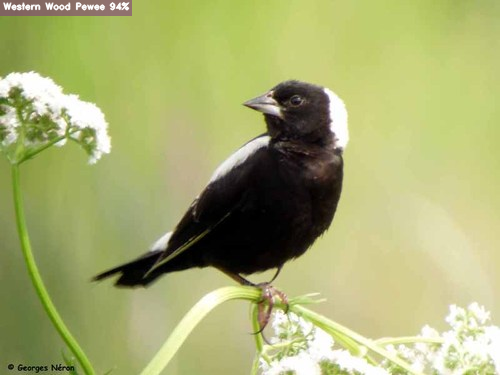

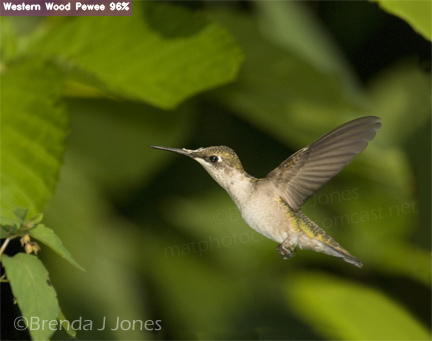

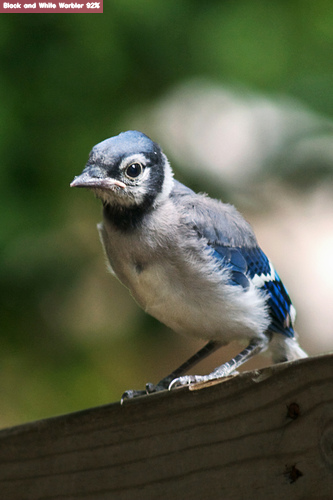

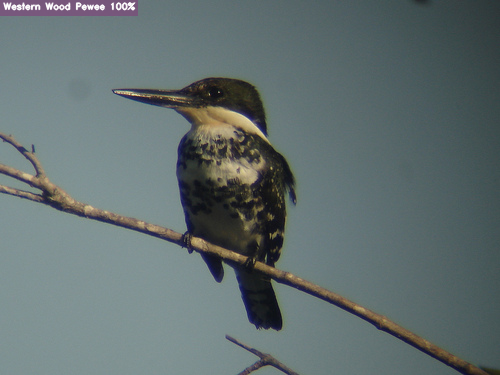

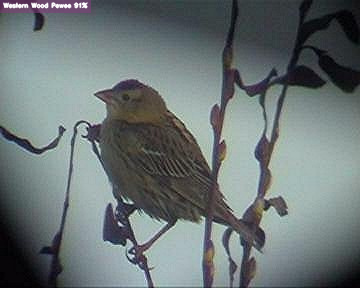

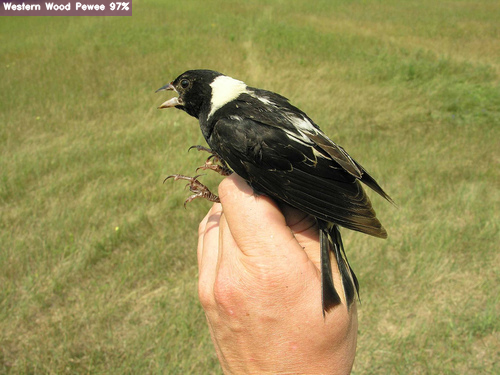

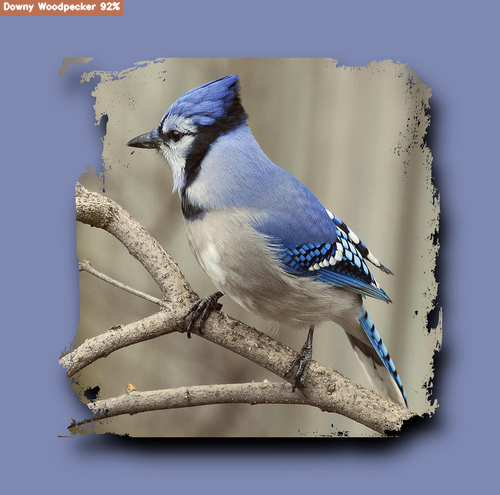

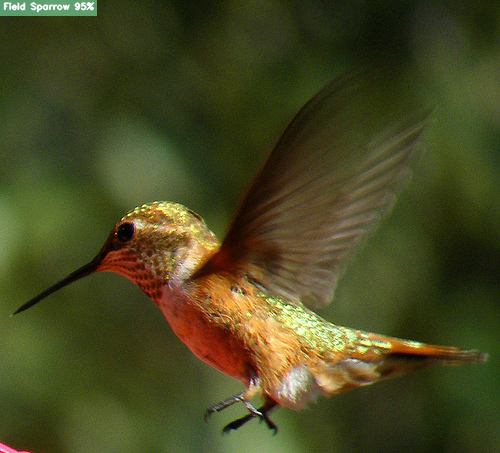

# of OOD images predicted as ID with High confidence: 56
# of imaged detected as OOD : 51 (91.07%)


In [14]:
test_images_count = 0
images_count_before = count_images_in_directory(
    OOD_COLLECTION_DIR, include_subdirectories=True
)

for image_path, image_numpy, prediction in infer_images_in_directory(
    OOD_COLLECTION_DIR_HIGH_PRED, deployment
):
    test_images_count += 1

    if test_images_count <= NUM_IMAGES_TO_SHOW:
        visualizer = Visualizer()
        result = visualizer.draw(image_numpy, prediction)
        visualizer.show_in_notebook(result)

images_count_after = count_images_in_directory(
    OOD_COLLECTION_DIR, include_subdirectories=True
)
ood_detected_images = images_count_after - images_count_before
print(f"# of OOD images predicted as ID with High confidence: {test_images_count}")
print(
    f"# of imaged detected as OOD : {ood_detected_images} ({ood_detected_images/test_images_count*100:.2f}%)"
)